In [64]:
import sys
sys.path.append("..")

import Essentials


In [65]:
import numpy as np

from sklearn.preprocessing import StandardScaler
import Essentials
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [66]:
# Загрузка данных
a = np.load('C:\\Users\\misha\\PLSSVD\\Data_Average.npz', allow_pickle=True)
x_train = a['X_train_1']
x_test = a['X_test_1']

In [67]:
timestamp_train = a['Y_train_1'][:, 1]
timestamp_test = a['Y_test_1'][:, 1]

In [68]:
y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)
# Разделение обучающих данных и временных меток на обучающую и валидационную выборки
x_train_split, x_val, y_train_split, y_val, timestamps_train_split, timestamps_val = train_test_split(
    x_train, y_train, timestamp_train, test_size=0.2, random_state=42
)

C:\Users\misha\AppData\Local\Temp\ipykernel_3276\3258080374.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_3276\3258080374.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)


In [69]:
y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)

C:\Users\misha\AppData\Local\Temp\ipykernel_3276\1763344097.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_3276\1763344097.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)


In [70]:
y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)

C:\Users\misha\AppData\Local\Temp\ipykernel_3276\1763344097.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_3276\1763344097.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)


In [71]:

class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, n_components=2):
        super().__init__(name)
        self.model = None
        self.coefficients = None
        self.n_components = n_components
        self.best_n_components = None  # Добавлен атрибут
        self.best_cv_score = None
        self.train(x_train, y_train, n_components)

    def preprocessing(self, x):
        return x

    def postprocessing(self, y):
        return y

    def evaluate_model(self, x):
        if self.model is None:
            raise ValueError("The model has not been trained yet.")
        return self.model.predict(x)

    def train(self, x_train, y_train, n_components):
        # Разделение данных на обучающую и валидационную выборки
        x_train_split, x_val, y_train_split, y_val = train_test_split(
            x_train, y_train, test_size=0.2, random_state=42
        )

        best_score = -np.inf
        best_n_components = None
        best_model = None

        # Поиск лучшей модели
        for i in range(1, n_components + 1):
            model = PLSRegression(n_components=i)
            model.fit(x_train_split, y_train_split)
            score = model.score(x_val, y_val)
            if score > best_score:
                best_score = score
                best_n_components = i
                best_model = model

        # Проверка, что лучшая модель была найдена
        if best_n_components is None:
            raise ValueError("No suitable number of components found.")

        # Сохранение лучшей модели
        self.model = best_model
        self.coefficients = best_model.coef_
        self.n_components = best_n_components
        self.best_cv_score = best_score

        # Сохранение валидационной выборки в атрибутах класса
        self.x_val = x_val
        self.y_val = y_val

    def validate(self, x_val, y_val):
        val_score = self.model.score(x_val, y_val)
        print(f"Validation R^2 score: {val_score:.3f}")

    def __str__(self):
        coefs_str = ", ".join([f"{coef:.3f}" for coef in self.coefficients.ravel()])
        return (f"Модель PLSSVD с {self.n_components} компонентами.\n"
                f"Коэффициенты регрессии: {coefs_str}\n"
                f"Лучший R^2 на тестовой выборке: {self.best_cv_score:.3f}")

In [72]:
sensor = PLSSVDSoftSensor('PLS Sensor', x_train, y_train, n_components=10)
sensor.train(x_train, y_train, n_components=10)

In [73]:
print(sensor)

Модель PLSSVD с 6 компонентами.
Коэффициенты регрессии: 0.192, 0.221, -0.257, 0.134, 0.156, -0.167, 0.024, 0.172, -0.198, -0.182, 0.172, -0.290, 0.255, 0.020, -0.014, -0.141, 0.133, 0.060, -0.410, -0.160, 0.563, -0.620, 0.240, 0.500, -0.477, 0.079, -0.610, 0.437, -1.090, -0.254, 0.049, 0.142, -0.210, 0.188, 0.063, 0.109, -0.461, 0.093, -0.040, 0.038, -0.099, -0.494, -0.227, 0.165, 0.009, 0.020, 0.215, 0.172, -0.131, -0.138, 0.140, -0.120, 0.119, -0.132, 0.112, -0.114, 0.236, -0.232, 0.271, -0.132, -0.186, 0.209, -0.050, 0.205, -0.067, -0.011, -0.315, -0.075, -0.169, -0.231, -0.013, -0.331, -0.272, -0.285, -0.380, 0.359, -0.229, 0.107, -0.246, -0.078, 0.144, 0.050, 0.260, -0.149, 0.095, -0.105, 0.001, -0.257, 0.233, 0.188, 0.121, 0.071, 0.336, 0.006, 0.096, 0.294
Лучший R^2 на тестовой выборке: 0.874


In [74]:
metric = Essentials.R2Metric()

In [75]:
test_visual = Essentials.Visualizer(sensor.x_val, sensor.y_val, timestamps_val, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                      0.874088


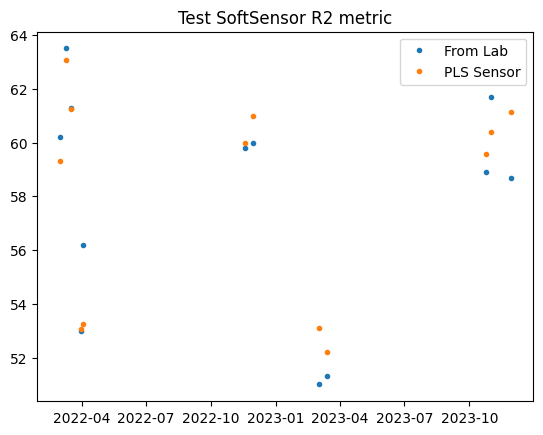

In [76]:
test_visual.visualize([sensor])